In [1]:
import tensorflow as tf
import keras
from keras import layers
from keras import regularizers
from keras.datasets import mnist
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt

In [2]:
orig = 28*28
inter = 64
latent = 2

inputs = keras.Input(shape = (orig, ))
h = layers.Dense(inter, activation = 'relu')(inputs)
zmean = layers.Dense(latent)(h)
zlog = layers.Dense(latent)(h)

In [3]:
from keras import backend as be

def sample(args):
    zmean, zlog = args
    epsilon = be.random_normal(shape = (be.shape(zmean)[0], latent), mean = 0, stddev = 0.1)
    return zmean + be.exp(zlog) + epsilon

z = layers.Lambda(sample)([zmean, zlog])

In [4]:
encoder = keras.Model(inputs, [zmean, zlog, z], name = 'encoder')
latentinputs = keras.Input(shape = (latent, ), name = 'zsampling')
x = layers.Dense(inter, activation = 'relu')(latentinputs)
outputs = layers.Dense(orig, activation = 'sigmoid')(x) 
decoder = keras.Model(latentinputs, outputs, name = 'decoder')
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name = 'vaemain')

In [5]:
recloss = keras.losses.binary_crossentropy(inputs, outputs)
recloss *= orig
klloss = 1 + zlog + be.square(zmean) - be.exp(zlog)
klloss = be.sum(klloss, axis=1)
klloss *= -0.5
vaeloss = be.mean(recloss + klloss)
vae.add_loss(vaeloss)
vae.compile(optimizer = 'adam')

In [6]:
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
xtrain = xtrain.astype('float32')/255
xtest = xtest.astype('float32') / 255.
xtrain = xtrain.reshape((len(xtrain), np.prod(xtrain.shape[1:])))
xtest = xtest.reshape((len(xtest), np.prod(xtest.shape[1:])))
vae.fit(xtrain, xtrain, epochs=100, batch_size=32, validation_data=(xtest, xtest)) 

Epoch 1/100
1875/1875 [==============================] - 3s 1ms/step - loss: -870851712.0000 - val_loss: -4318317568.0000
Epoch 2/100
1875/1875 [==============================] - 3s 1ms/step - loss: -20352985088.0000 - val_loss: -48245891072.0000
Epoch 3/100
1875/1875 [==============================] - 3s 2ms/step - loss: -101222301696.0000 - val_loss: -178761826304.0000
Epoch 4/100
1875/1875 [==============================] - 3s 2ms/step - loss: -289590607872.0000 - val_loss: -445252075520.0000
Epoch 5/100
1875/1875 [==============================] - 3s 1ms/step - loss: -635218427904.0000 - val_loss: -901204934656.0000
Epoch 6/100
1875/1875 [==============================] - 3s 1ms/step - loss: -1195219353600.0000 - val_loss: -1609807036416.0000
Epoch 7/100
1875/1875 [==============================] - 3s 1ms/step - loss: -2031634350080.0000 - val_loss: -2638578712576.0000
Epoch 8/100
1875/1875 [==============================] - 3s 1ms/step - loss: -3216070148096.0000 - val_loss: -4063

1875/1875 [==============================] - 3s 1ms/step - loss: -4904006543474688.0000 - val_loss: -5207688648589312.0000
Epoch 63/100
1875/1875 [==============================] - 3s 1ms/step - loss: -5207452425388032.0000 - val_loss: -5527560632926208.0000
Epoch 64/100
1875/1875 [==============================] - 3s 1ms/step - loss: -5524778030989312.0000 - val_loss: -5861632316014592.0000
Epoch 65/100
1875/1875 [==============================] - 3s 1ms/step - loss: -5855980139053056.0000 - val_loss: -6210201124339712.0000
Epoch 66/100
1875/1875 [==============================] - 3s 2ms/step - loss: -6202384820731904.0000 - val_loss: -6575280323821568.0000
Epoch 67/100
1875/1875 [==============================] - 3s 2ms/step - loss: -6563417624150016.0000 - val_loss: -6954900135084032.0000
Epoch 68/100
1875/1875 [==============================] - 3s 2ms/step - loss: -6940019684016128.0000 - val_loss: -7351358902501376.0000
Epoch 69/100
1875/1875 [==============================] - 3s 

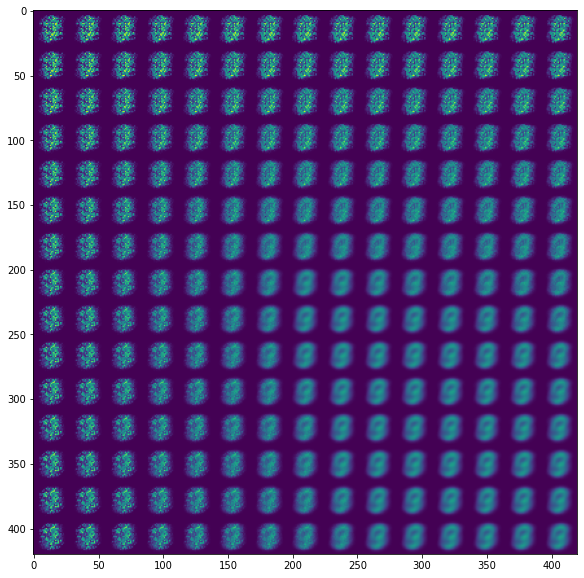

In [7]:
n = 15
digsize = 28
fig = np.zeros((digsize*n, digsize*n))
gx = np.linspace(-15, 15, n)
gy = np.linspace(-15, 15, n)
for i, yi in enumerate(gx):
    for j, xi in enumerate(gy):
        zsample =  np.array([[xi, yi]])
        xdec = decoder.predict(zsample)
        digit = xdec[0].reshape(digsize, digsize)
        fig[i * digsize: (i + 1) * digsize, j * digsize: (j + 1) * digsize] = digit
plt.figure(figsize=(10,10))
plt.imshow(fig)
plt.show()